##Environment Set Up

In [0]:
%pip install lightgbm
%pip install matplotlib

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# Standard library
from datetime import datetime, timedelta
import math
# Data manipulation
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve, 
    auc
)
import lightgbm as lgb
from functools import reduce
import operator
import json
import os, pickle
import shap

##Data Overview
- Train/Test table: apology_model_14d_v0
- Validation Table: apology_model_7d_v0
- Original distribution 
  - extra_ac vs no_ac - regardless escalation status: 3.5:96.5
  - extra_ac vs no_ac - within escalation: 25:75

##Load Existing Data

In [0]:
# train_df = pd.read_csv('/dbfs/Workspace/Users/yvette.yu@doordash.com/apology-model/apology-train_df_transformed_v0')
test_df = pd.read_csv('/dbfs/Workspace/Users/yvette.yu@doordash.com/apology-model/apology-test_df_transformed_v0')

Columns (24,25,26,38,39,53,54,55,56,57,58,59,194) have mixed types. Specify dtype option on import or set low_memory=False.


##Feature Set

In [0]:
cat_feature = ['DEFAULT_ZIP_CODE',
 'PAYMENT_METHOD',
 'SH_LATEST_REPORT_ISSUE',
 'SH_FIRST_REPORT_ISSUE',
 'IS_NON_ABUSER',
 'ORDER_TIME_OF_DAY',
 'MOST_FREQ_MTO_ISSUE',
 'LATEST_MTO_ISSUE',
 'FRAUD_CNR_REQUEST_RATIO_LD_L180D',
 'FREQ_CATEGORY',
 'DEFECT_CATEGORY',
 'SUBMIT_PLATFORM',
 'IF_DASHER_MANUAL_ASSIGNED']

num_feature = ['TIP_PERCENTAGE',
 'FRAUD_CNR_REQUEST_RATIO_L60D',
 'ORDER_COUNT_L7D',
 'MOST_FREQ_MTO_COUNT',
 'IS_20_MIN_LATE',
 'CREDIT_REFUND_ORDER_COST_LIFETIME',
 'IS_ELITE_CX',
 'SH_CNR_RATIO',
 'SH_CNR',
 'SH_IS_REJET',
 'AVG_TIP_LIFETIME',
 'MTO_ORDER_COUNT_LIFETIME',
 'TOTAL_ITEM_COUNT',
 'FRAUD_CNR_REQUEST_RATIO_L180D',
 'PROMOTIONS',
 'FRAUD_CNR_APPROVED_REQUESTS_COUNT_L180D',
 'SH_IS_CREDITS',
 'SH_IS_REDELIVERY',
 'IS_LATE',
 'IS_OSI',
 'AVG_SPEND_LIFETIME',
 'SH_IS_REFUND',
 'IS_ND',
 'IS_PFQ',
 'MTO_ORDER_COUNT_L90D',
 'SUBTOTAL',
 'IS_MnI',
 'IS_WHALE_CX',
 'ML_CX_CNR_RISK_V1_SCORE',
 'FRAUD_CNR_REQUESTED_DELIVERIES_COUNT_L180D',
 'MTO_ORDER_COUNT_L12M',
 'FRAUD_CNR_APPROVED_REQUESTS_COUNT_L60D',
 'TIP',
 'FRAUD_CNR_ND_ORDERS_COUNT_L60D',
 'ACTUAL_VP_RAW_AMT_L12M']

##Convert Feature dtypes

In [0]:
# train_df[cat_feature] = train_df[cat_feature].astype('category')
# train_df[num_feature] = train_df[num_feature].astype('float')
test_df[cat_feature] = test_df[cat_feature].astype('category')
test_df[num_feature] = test_df[num_feature].astype('float')

##Load Model Artifacts
- saved fold-1 model to: /dbfs/Workspace/Users/yvette.yu@doordash.com/apology-model/v1_lgb_1125_fold1.pkl
- saved fold-2 model to: /dbfs/Workspace/Users/yvette.yu@doordash.com/apology-model/v1_lgb_1125_fold2.pkl
- saved fold-3 model to: /dbfs/Workspace/Users/yvette.yu@doordash.com/apology-model/v1_lgb_1125_fold3.pkl
- CV metrics saved to: /dbfs/Workspace/Users/yvette.yu@doordash.com/apology-model/v1_lgb_1125_cv_metrics.csv
- Feature importances saved to: /dbfs/Workspace/Users/yvette.yu@doordash.com/apology-model/v1_lgb_1125_feature_importance.csv

In [0]:
features = ['SH_LATEST_REPORT_ISSUE', 'TOTAL_ITEM_COUNT', 'SH_FIRST_REPORT_ISSUE', 'PAYMENT_METHOD', 'DEFECT_CATEGORY', 'SH_CNR', 'FRAUD_CNR_APPROVED_REQUESTS_COUNT_L60D', 'SH_IS_CREDITS', 'SUBTOTAL', 'TIP', 'IS_MnI', 'FRAUD_CNR_REQUEST_RATIO_L60D', 'SH_CNR_RATIO', 'DEFAULT_ZIP_CODE', 'PROMOTIONS', 'SH_IS_REFUND', 'FRAUD_CNR_APPROVED_REQUESTS_COUNT_L180D', 'TIP_PERCENTAGE', 'MTO_ORDER_COUNT_L12M', 'SH_IS_REJET', 'IS_20_MIN_LATE', 'SH_IS_REDELIVERY', 'ML_CX_CNR_RISK_V1_SCORE', 'MTO_ORDER_COUNT_LIFETIME', 'FRAUD_CNR_REQUEST_RATIO_LD_L180D', 'FRAUD_CNR_REQUESTED_DELIVERIES_COUNT_L180D', 'IS_WHALE_CX', 'IS_ELITE_CX', 'IF_DASHER_MANUAL_ASSIGNED', 'FRAUD_CNR_REQUEST_RATIO_L180D', 'MTO_ORDER_COUNT_L90D', 'MOST_FREQ_MTO_COUNT', 'AVG_SPEND_LIFETIME', 'IS_PFQ', 'FREQ_CATEGORY', 'IS_LATE', 'FRAUD_CNR_ND_ORDERS_COUNT_L60D', 'IS_OSI', 'SUBMIT_PLATFORM', 'ORDER_COUNT_L7D', 'ACTUAL_VP_RAW_AMT_L12M', 'ORDER_TIME_OF_DAY', 'MOST_FREQ_MTO_ISSUE', 'IS_ND', 'AVG_TIP_LIFETIME', 'IS_NON_ABUSER', 'LATEST_MTO_ISSUE', 'CREDIT_REFUND_ORDER_COST_LIFETIME']

In [0]:
_local_path = '/dbfs/Workspace/Users/yvette.yu@doordash.com/apology-model/v1_lgb_1125_fold3.pkl'
with open(_local_path, 'rb') as f:
    _lgb = pickle.load(f)

##Model Inference

In [0]:
pred_probs = _lgb.predict(test_df[features])

##Model Performance Reference

ROC AUC (Train): 0.8697


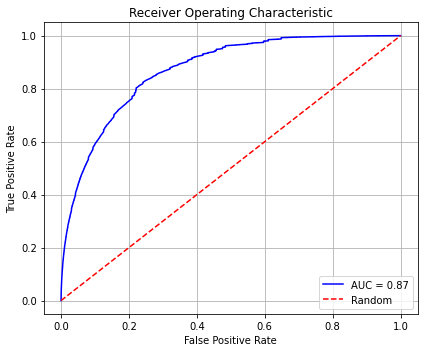

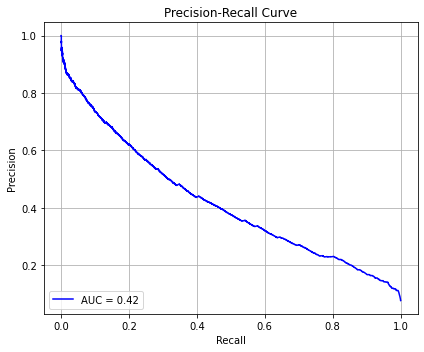


Precision & Recall at specific thresholds:
   threshold  precision  recall
0        0.5     0.3717  0.5066
1        0.6     0.4530  0.3779
2        0.7     0.5531  0.2629
3        0.8     0.6796  0.1503
4        0.9     0.8272  0.0418


In [0]:
pred_probs = _lgb.predict(
    test_df[features]
)
predictions = pd.DataFrame(
    {
        'pred_0': 1 - pred_probs,
        'pred_1': pred_probs
    }
)
auc_df = pd.concat([predictions, test_df['IF_AC'].reset_index(drop=True)], axis=1)
auc_df.rename(columns={auc_df.columns[-1]: 'LABEL'}, inplace=True)

# --- ROC AUC ---
roc_auc = roc_auc_score(auc_df['LABEL'].astype(int), auc_df['pred_1'])
print(f"ROC AUC (Test): {roc_auc:.4f}")
# Plot ROC curve
fpr, tpr, _ = roc_curve(auc_df['LABEL'], auc_df['pred_1'])
plt.figure(figsize=(6, 5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(auc_df['LABEL'], auc_df['pred_1'])
pr_auc = auc(recall, precision)  # FIX: use recall, precision (not fpr, tpr)
# Plot PR curve
plt.figure(figsize=(6, 5))
plt.title('Precision-Recall Curve')
plt.plot(recall, precision, 'b', label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Precision & Recall at specific thresholds ---
threshold_list = [0.5, 0.6, 0.7, 0.8, 0.9]
results = []
for th in threshold_list:
    preds_bin = (auc_df['pred_1'] >= th).astype(int)
    tp = ((preds_bin == 1) & (auc_df['LABEL'] == 1)).sum()
    fp = ((preds_bin == 1) & (auc_df['LABEL'] == 0)).sum()
    fn = ((preds_bin == 0) & (auc_df['LABEL'] == 1)).sum()
    precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
    results.append({
        'threshold': th,
        'precision': round(precision_val, 4),
        'recall': round(recall_val, 4)
    })
pr_table = pd.DataFrame(results)
print("\nPrecision & Recall at specific thresholds:")
print(pr_table)